In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [3]:
crimes = pd.read_csv('~/data/cleaned_chicago_crime_data.csv')

In [4]:
crimes.index = crimes['ID'] # make the index the actual case number
# remove columns that are unnecessary for the analysis and would probably just slow our code down
crimes = crimes.drop(['Beat', 'FBI Code','Updated On', 'Case Number', 'Block', 'IUCR', 'ID', 'Unnamed: 0','Description', 'Ward', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], axis=1)

In [5]:
crime_types = crimes['Primary Type'].unique().tolist()

### Begin cleaning data

1. Remove NaN values
2. standardize the crime type to get rid of the uppercase, standardize the non-criminal type
3. standardize the location description

There are actually no Nan values to remove! Government data is reliable I guess. The only NaN values are location, but we still know the district, so as long as we don't end up needing location later on, this is fine

In [6]:
to_drop = crimes[crimes.isnull().any(axis=1)]
to_drop;

In [7]:
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [8]:
def standardize_location(string):
    if type(string) == str:
        string = string.lower()
        if 'airport' in string:
            return 'airport'
    return string

In [9]:
crimes['Primary Type'] = crimes['Primary Type'].apply(standardize_primary_type) # clean data 
crimes['location'] = crimes['Location Description'].apply(standardize_location)

In [10]:
# be careful if you run this one, only run it once it won't work the second time 
crimes = crimes.drop(['Location Description','Community Area'],axis=1)

In [11]:
crimes = crimes.rename(columns = {'Location': 'Coordinates'})

In [12]:
violents = ['BATTERY','ASSAULT','CRIM SEXUAL ASSAULT', 'ARSON','HOMICIDE']

In [13]:
violent_crimes = crimes[ (crimes['Primary Type'] == 'battery') | (crimes['Primary Type'] == 'assault') | (crimes['Primary Type'] == 'sexual assault') | (crimes['Primary Type'] == 'arson') | (crimes['Primary Type'] == 'homicide')]

In [14]:
crimes.head()

,Date,Primary Type,Arrest,Domestic,District,Year,Coordinates,location
ID,,,,,,,,
10000092,03/18/2015 07:44:00 PM,battery,False,False,11.0,2015,"(41.891398861, -87.744384567)",street
10000094,03/18/2015 11:00:00 PM,other,True,False,7.0,2015,"(41.773371528, -87.665319468)",street
10000095,03/18/2015 10:45:00 PM,battery,False,True,2.0,2015,"(41.81386068, -87.596642837)",apartment
10000096,03/18/2015 10:30:00 PM,battery,False,False,2.0,2015,"(41.800802415, -87.622619343)",apartment
10000097,03/18/2015 09:00:00 PM,robbery,False,False,11.0,2015,"(41.878064761, -87.743354013)",sidewalk


## Overall, our question is, does the district a crime was committed in or the type of crime predict whether an arrest was made for that crime

First, I will fit a linear regression model to see how district predicts arrest rate.
1. Create a dataframe with index being the district, one column is the arrest rate for a particular crime, we will look at the top three crimes. 

In [15]:
crimes['Primary Type'].value_counts().nlargest(3)

theft              1431574
battery            1241925
criminal damage     776765
Name: Primary Type, dtype: int64

In [16]:
districts = crimes['District'].unique().tolist()
districts.remove(21)

In [17]:
district_cache = {}
for district in districts:
    district_cache[district] = crimes[ crimes['District'] == district ]

In [18]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    
    district_df = district_cache[district]
    
    arrest_occurred = district_df[district_df['Arrest'] == True]
    
    dist_pred_arrest.loc[district,'Reported Theft'] = len(district_df[district_df['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']

    dist_pred_arrest.loc[district,'Reported Battery'] = len(district_df[district_df['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']

    
    dist_pred_arrest.loc[district,'Reported Criminal Damage'] = len(district_df[district_df['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage Arrest Rate'] = dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Criminal Damage']

    
    
    
    


In [19]:
assert 21 not in dist_pred_arrest.index

In [20]:
dist_pred_arrest = dist_pred_arrest.sort_index()
dist_pred_arrest['District'] = dist_pred_arrest.index
dist_pred_arrest['Theft Arrest Rate'].values

array([0.17419393, 0.11993026, 0.10944354, 0.09312083, 0.09112635,
       0.17034051, 0.08365324, 0.13923535, 0.13445531, 0.09331917,
       0.09741442, 0.0920011 , 0.07810935, 0.08949501, 0.07611622,
       0.13456216, 0.12902263, 0.10413405, 0.13309901, 0.09003009,
       0.11233452, 0.18039961])

In [21]:
print('Max arrest rate: {0}\tDistrict: {1}'.format(dist_pred_arrest['Theft Arrest Rate'].max(),dist_pred_arrest['Theft Arrest Rate'].idxmax()))
print('Min arrest rate: {0}\tDistrict: {1}'.format(dist_pred_arrest['Theft Arrest Rate'].min(),dist_pred_arrest['Theft Arrest Rate'].idxmin()))



Max arrest rate: 0.18039961160268597	District: 25.0
Min arrest rate: 0.07611621646709366	District: 16.0


In [22]:
dist_pred_arrest.corr();

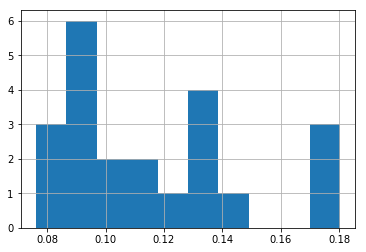

In [23]:
thefts = dist_pred_arrest['Theft Arrest Rate']
thefts.hist()

In [24]:
# want to predict whether an arrest was made from the district. So y is arrests, X is districts
y = dist_pred_arrest['Theft Arrest Rate']
X = districts
model = sm.OLS(y,X)
results = model.fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Theft Arrest Rate   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     50.10
Date:                Thu, 14 Mar 2019   Prob (F-statistic):           5.53e-07
Time:                        14:17:29   Log-Likelihood:                 29.073
No. Observations:                  22   AIC:                            -56.15
Df Residuals:                      21   BIC:                            -55.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071      0.001      7.078      0.000       0.005       0.009
==============================================================================
Omnibus:                        0.825   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.821
Skew:                          -0.292   Prob(JB):                        0.663
Kurtosis:                       2.255   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

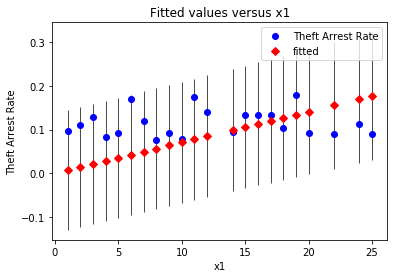

In [26]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results, 0, ax=ax)

So I have shown that there is not likely a linear relationship between district and theft arrest rate - check on A3

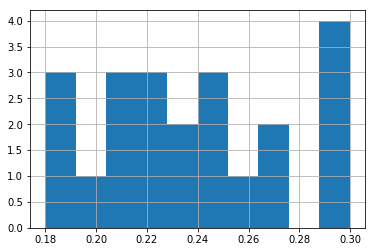

In [27]:
battery = dist_pred_arrest['Battery Arrest Rate']
battery.hist()

In [28]:
# want to predict whether an arrest was made from the district. So y is arrest rate, X is districts
y = dist_pred_arrest['Battery Arrest Rate']
X = districts
model = sm.OLS(y,X)
results = model.fit()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Battery Arrest Rate   R-squared:                       0.751
Model:                             OLS   Adj. R-squared:                  0.739
Method:                  Least Squares   F-statistic:                     63.37
Date:                 Thu, 14 Mar 2019   Prob (F-statistic):           8.91e-08
Time:                         14:17:30   Log-Likelihood:                 15.366
No. Observations:                   22   AIC:                            -28.73
Df Residuals:                       21   BIC:                            -27.64
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0148      0.002      7.961      0.000       0.011       0.019
==============================================================================
Omnibus:                        1.334   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.001
Skew:                          -0.502   Prob(JB):                        0.606
Kurtosis:                       2.710   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

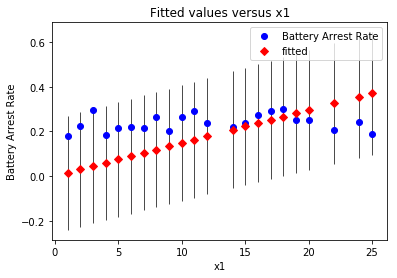

In [30]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results, 0, ax=ax)

In [31]:
rate_theft = dist_pred_arrest['Theft Arrest Rate'].values
rate_battery = dist_pred_arrest['Battery Arrest Rate'].values
rate_damage = dist_pred_arrest['Criminal Damage Arrest Rate'].values

In [32]:
st_theft, p_theft = stats.normaltest(rate_theft)
st_battery, p_battery = stats.normaltest(rate_theft)
st_damage, p_damage = stats.normaltest(rate_theft)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


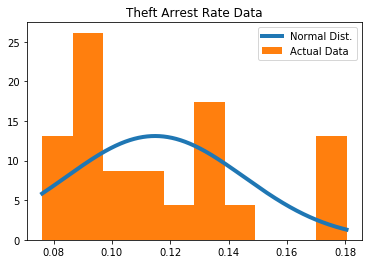

In [33]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_theft.min(), rate_theft.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_theft), np.std(rate_theft))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_theft, normed=True, label='Actual Data');
plt.title('Theft Arrest Rate Data')
plt.legend();

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


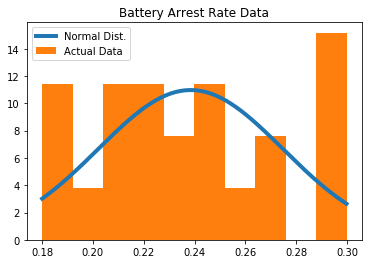

In [34]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_battery.min(), rate_battery.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_battery), np.std(rate_battery))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_battery, normed=True, label='Actual Data');
plt.title('Battery Arrest Rate Data')
plt.legend();

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


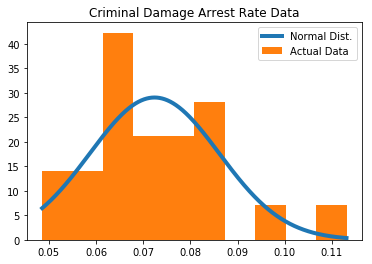

In [35]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_damage.min(), rate_damage.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_damage), np.std(rate_damage))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_damage, normed=True, label='Actual Data');
plt.title('Criminal Damage Arrest Rate Data')
plt.legend();

In [36]:
theft_arrest_average = rate_theft.mean()
battery_arrest_average = rate_battery.mean()
damage_arrest_average = rate_damage.mean()

In [37]:
print('Theft Arrest Rate Average\tBattery Arrest Average\tCriminal Damage Arrest Average\n{0}\t\t{1}\t{2}'.format(theft_arrest_average,battery_arrest_average,damage_arrest_average))

Theft Arrest Rate Average	Battery Arrest Average	Criminal Damage Arrest Average
0.1147971208577779		0.23846304811858918	0.07238967477751355


Battery is more likely to result in an arrest, on average, doesn't matter where you are. Criminal damage is the least likely to result in an arrest.

Now, I should move onto the actual analysis of the question: what I want to do is show that there is a significant difference between districts in terms of these averages. Lets try to start with just comparing districts 1 and 2

So my initial findings have indicated that there is in fact a very significant difference between the districts when it comes to the proportion of crimes that result in arrests.

I will now turn the above code into a function to apply the two sample t test to all pairs of districts, which is n^2 time.

In [38]:
def get_stats(dist_1,dist_2):
    dist_1_battery = dist_1[dist_1['Primary Type'] == 'battery']
    dist_2_battery = dist_2[dist_2['Primary Type'] == 'battery']
    
    dist_1_theft = dist_1[dist_1['Primary Type'] == 'theft']
    dist_2_theft = dist_2[dist_2['Primary Type'] == 'theft']
    
    dist_1_damage = dist_1[dist_1['Primary Type'] == 'criminal damage']
    dist_2_damage = dist_2[dist_2['Primary Type'] == 'criminal damage']

    print('--------Theft Statistics---------\n')
    print('*******First District********')
    print('Theft Arrest Mean:\t{0}'.format(dist_1_theft['Arrest'].mean()))
    print('Number of Thefts:\t{0}'.format(len(dist_1_theft['Arrest'])))
    
    print('*******Second District********')
    print('Theft Arrest Mean:\t{0}'.format(dist_2_theft['Arrest'].mean()))
    print('Number of Thefts:\t{0}'.format(len(dist_2_theft['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_theft['Arrest'], dist_2_theft['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))

    print('\n--------Battery Statistics---------\n')
    print('*******First District********')
    print('Battery Arrest Mean:\t{0}'.format(dist_1_battery['Arrest'].mean()))
    print('Number of Batteries:\t{0}'.format(len(dist_1_battery['Arrest'])))
    
    print('*******Second District********')
    print('Battery Arrest Mean:\t{0}'.format(dist_2_battery['Arrest'].mean()))
    print('Number of Batteries:\t{0}'.format(len(dist_2_battery['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_battery['Arrest'], dist_2_battery['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))

    print('\n--------Criminal Damage Statistics---------\n')
    print('*******First District********')
    print('Damage Arrest Mean:\t{0}'.format(dist_1_damage['Arrest'].mean()))
    print('Number of Damages:\t{0}'.format(len(dist_1_damage['Arrest'])))
    
    print('*******Second District********')
    print('Damage Arrest Mean:\t{0}'.format(dist_2_damage['Arrest'].mean()))
    print('Number of Damages:\t{0}'.format(len(dist_2_damage['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_damage['Arrest'], dist_2_damage['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))


In [39]:
get_stats(district_cache[2.0],district_cache[4.0])

--------Theft Statistics---------

*******First District********
Theft Arrest Mean:	0.11993025666802802
Number of Thefts:	63662
*******Second District********
Theft Arrest Mean:	0.09312083213681759
Number of Thefts:	62682
Test Statistic:	15.451610157362474
P Value:	8.243386488465634e-54

--------Battery Statistics---------

*******First District********
Battery Arrest Mean:	0.2157751308980679
Number of Batteries:	65318
*******Second District********
Battery Arrest Mean:	0.20160553043870305
Number of Batteries:	79849
Test Statistic:	6.6184700585421865
P Value:	3.641908730144757e-11

--------Criminal Damage Statistics---------

*******First District********
Damage Arrest Mean:	0.06647559171597633
Number of Damages:	32448
*******Second District********
Damage Arrest Mean:	0.05563894923958128
Number of Damages:	50630
Test Statistic:	6.4246400083977235
P Value:	1.3289382600084144e-10
